<a href="https://colab.research.google.com/github/Faiqazmi/RepoTugasBesar_TKC_047_059/blob/main/3_Model_TKC_047_059.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faiq Azmi Nurfaizi           (201810370311047)
# Muhammad Reza Fahlopy Dharma (201810370311059)

# Model 1

In [ ]:
from google.colab import files 
from pathlib import Path
import os
import pandas as pd
import json
import zipfile
import matplotlib.pyplot as plt

In [ ]:
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rezafdz","key":"fd16295d7b817e274541292110c8f784"}'}

In [ ]:
api_token = {"username":"rezafdz","key":"fd16295d7b817e274541292110c8f784"}
with open('kaggle.json', 'w') as file: 
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [00:48<00:00, 35.2MB/s]
100% 3.24G/3.24G [00:48<00:00, 71.2MB/s]


In [ ]:
from zipfile import ZipFile 
file_name = "a-large-scale-fish-dataset.zip" #

with ZipFile(file_name,'r') as zip : 
  zip.extractall() 
  print('Berhasil') 

Berhasil


In [ ]:
dataset_path = Path(r'/content/Fish_Dataset')

file_path = list(dataset_path.glob(r'**/*.png'))


labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [ ]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

,image,label
0,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
1,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
2,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
3,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
4,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat


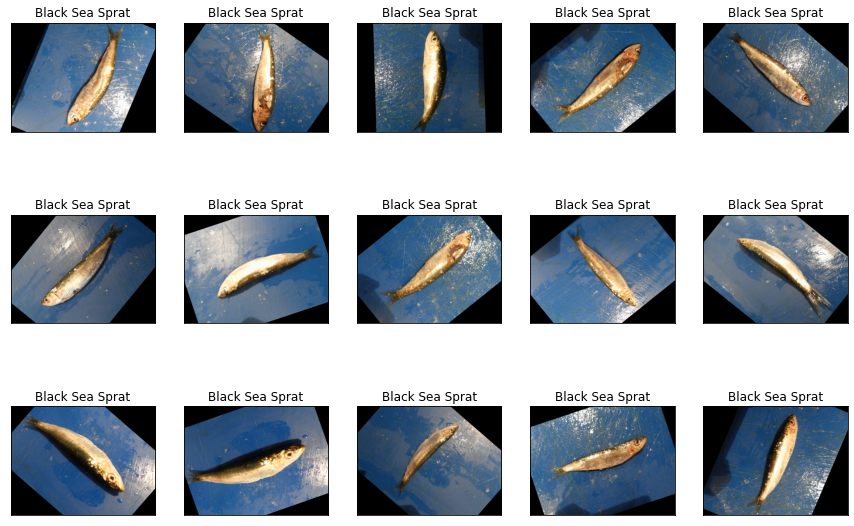

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [ ]:
df.label.value_counts()

Hourse Mackerel GT       1000
Red Sea Bream            1000
Gilt-Head Bream          1000
Striped Red Mullet GT    1000
Shrimp                   1000
Sea Bass                 1000
Trout                    1000
Sea Bass GT              1000
Striped Red Mullet       1000
Shrimp GT                1000
Red Sea Bream GT         1000
Gilt-Head Bream GT       1000
Black Sea Sprat GT       1000
Trout GT                 1000
Red Mullet               1000
Black Sea Sprat          1000
Red Mullet GT            1000
Hourse Mackerel          1000
Name: label, dtype: int64

In [ ]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Striped Red Mullet    1000
Red Sea Bream         1000
Trout                 1000
Sea Bass              1000
Shrimp                1000
Gilt-Head Bream       1000
Hourse Mackerel       1000
Black Sea Sprat       1000
Red Mullet            1000
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD, Nadam

In [ ]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [ ]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (5040, 2)
Shape of test data (2700, 2)
Shape of validation data (1260, 2)


In [ ]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 5040 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.
Found 1260 validated image filenames belonging to 9 classes.


In [ ]:
input_shape = (200, 200, 3)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, validation_data=val, epochs=100)

Epoch 1/100
158/158 [==============================] - 135s 780ms/step - loss: 2.1175 - accuracy: 0.1518 - val_loss: 1.8907 - val_accuracy: 0.2421
Epoch 2/100
158/158 [==============================] - 119s 756ms/step - loss: 1.6295 - accuracy: 0.3171 - val_loss: 1.3391 - val_accuracy: 0.4389
Epoch 3/100
158/158 [==============================] - 120s 759ms/step - loss: 1.2877 - accuracy: 0.4712 - val_loss: 1.0824 - val_accuracy: 0.5714
Epoch 4/100
158/158 [==============================] - 120s 760ms/step - loss: 1.0889 - accuracy: 0.5692 - val_loss: 0.9263 - val_accuracy: 0.6389
Epoch 5/100
158/158 [==============================] - 120s 758ms/step - loss: 1.0135 - accuracy: 0.5921 - val_loss: 0.8312 - val_accuracy: 0.6802
Epoch 6/100
158/158 [==============================] - 121s 765ms/step - loss: 0.9081 - accuracy: 0.6423 - val_loss: 0.7530 - val_accuracy: 0.7024
Epoch 7/100
158/158 [==============================] - 121s 767ms/step - loss: 0.8211 - accuracy: 0.6770 - val_loss: 0

In [ ]:
model.save('model1-fish1.h5')

In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

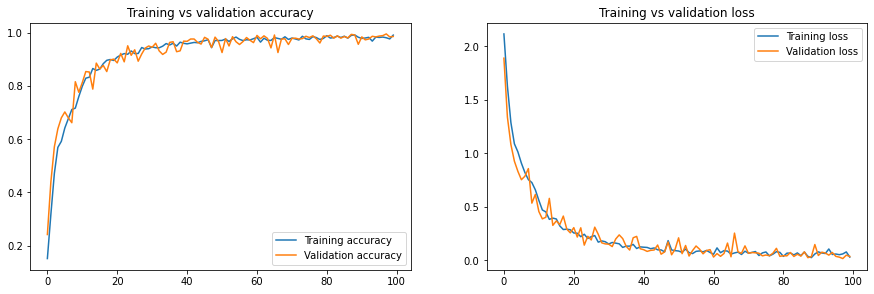

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [ ]:
pred = model.predict(test)

In [ ]:
import numpy as np
pred = np.argmax(pred, axis=1)

In [ ]:
labels = train.class_indices
labels

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [ ]:
labels = dict((v,k) for k, v in labels.items())
labels

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

In [ ]:
y_pred = [labels[k] for k in pred]
print(classification_report(x_test.label, y_pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       305
   Gilt-Head Bream       0.97      0.97      0.97       287
   Hourse Mackerel       0.99      1.00      1.00       298
        Red Mullet       1.00      1.00      1.00       290
     Red Sea Bream       0.99      0.96      0.98       291
          Sea Bass       0.99      0.98      0.98       301
            Shrimp       1.00      1.00      1.00       293
Striped Red Mullet       1.00      1.00      1.00       314
             Trout       0.96      1.00      0.98       321

          accuracy                           0.99      2700
         macro avg       0.99      0.99      0.99      2700
      weighted avg       0.99      0.99      0.99      2700



In [ ]:
print(confusion_matrix(x_test.label, y_pred))

[[304   0   0   0   0   1   0   0   0]
 [  0 278   1   0   2   2   0   0   4]
 [  0   0 298   0   0   0   0   0   0]
 [  0   0   0 290   0   0   0   0   0]
 [  1   5   0   0 279   0   0   0   6]
 [  0   3   1   0   0 294   0   0   3]
 [  0   0   0   0   0   0 293   0   0]
 [  0   0   0   0   0   0   0 314   0]
 [  0   0   0   0   0   0   0   0 321]]


In [ ]:
test_accuracy = model.evaluate(test)[1]

85/85 [==============================] - 52s 615ms/step - loss: 0.0368 - accuracy: 0.9900


# Model 2

In [1]:
from google.colab import files 
from pathlib import Path
import os
import pandas as pd
import json
import zipfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD, Nadam

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rezafdz","key":"fd16295d7b817e274541292110c8f784"}'}

In [3]:
api_token = {"username":"rezafdz","key":"fd16295d7b817e274541292110c8f784"}
with open('kaggle.json', 'w') as file: 
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 

In [5]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [00:49<00:00, 48.5MB/s]
100% 3.24G/3.24G [00:49<00:00, 70.8MB/s]


In [6]:
from zipfile import ZipFile 
file_name = "a-large-scale-fish-dataset.zip" #

with ZipFile(file_name,'r') as zip : 
  zip.extractall() 
  print('Berhasil') 

Berhasil


In [7]:
dataset_path = Path(r'/content/Fish_Dataset')

file_path = list(dataset_path.glob(r'**/*.png'))


labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [8]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

,image,label
0,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
1,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
2,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
3,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
4,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat


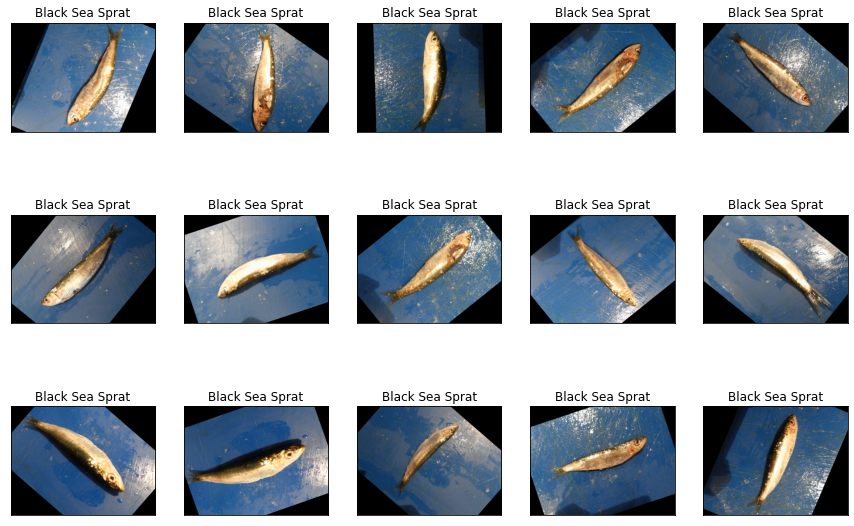

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [10]:
df.label.value_counts()

Striped Red Mullet       1000
Striped Red Mullet GT    1000
Hourse Mackerel          1000
Gilt-Head Bream GT       1000
Trout GT                 1000
Black Sea Sprat GT       1000
Red Mullet GT            1000
Black Sea Sprat          1000
Trout                    1000
Red Sea Bream            1000
Shrimp                   1000
Shrimp GT                1000
Sea Bass                 1000
Gilt-Head Bream          1000
Red Mullet               1000
Red Sea Bream GT         1000
Hourse Mackerel GT       1000
Sea Bass GT              1000
Name: label, dtype: int64

In [11]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Trout                 1000
Black Sea Sprat       1000
Striped Red Mullet    1000
Red Mullet            1000
Gilt-Head Bream       1000
Hourse Mackerel       1000
Sea Bass              1000
Shrimp                1000
Red Sea Bream         1000
Name: label, dtype: int64

In [12]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [13]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (5040, 2)
Shape of test data (2700, 2)
Shape of validation data (1260, 2)


In [14]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 5040 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.
Found 1260 validated image filenames belonging to 9 classes.


In [15]:
input_shape = (200, 200, 3)
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [16]:
model2.compile(optimizer="SGD", loss='categorical_crossentropy', metrics=["accuracy"])
#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model2.fit(train, validation_data=val, epochs=100)

Epoch 1/100
158/158 [==============================] - 134s 781ms/step - loss: 2.1948 - accuracy: 0.1288 - val_loss: 2.1919 - val_accuracy: 0.1500
Epoch 2/100
158/158 [==============================] - 118s 746ms/step - loss: 2.1856 - accuracy: 0.1468 - val_loss: 2.1703 - val_accuracy: 0.1730
Epoch 3/100
158/158 [==============================] - 117s 743ms/step - loss: 2.1487 - accuracy: 0.1667 - val_loss: 2.0857 - val_accuracy: 0.1865
Epoch 4/100
158/158 [==============================] - 117s 741ms/step - loss: 2.0756 - accuracy: 0.1976 - val_loss: 1.9973 - val_accuracy: 0.2143
Epoch 5/100
158/158 [==============================] - 117s 742ms/step - loss: 2.0117 - accuracy: 0.2192 - val_loss: 1.9403 - val_accuracy: 0.2579
Epoch 6/100
158/158 [==============================] - 117s 739ms/step - loss: 1.9791 - accuracy: 0.2355 - val_loss: 1.9320 - val_accuracy: 0.2548
Epoch 7/100
158/158 [==============================] - 115s 731ms/step - loss: 1.9496 - accuracy: 0.2506 - val_loss: 1

In [17]:
model2.save('model2-fish1.h5')

In [18]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

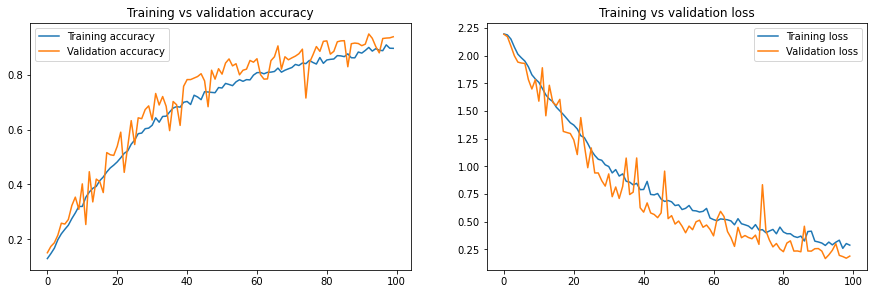

In [19]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [20]:
pred = model2.predict(test)

In [21]:
import numpy as np
pred = np.argmax(pred, axis=1)

In [22]:
labels = train.class_indices
labels

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [23]:
labels = dict((v,k) for k, v in labels.items())
labels

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

In [24]:
y_pred = [labels[k] for k in pred]
print(classification_report(x_test.label, y_pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.93      0.98      0.95       305
   Gilt-Head Bream       0.93      0.87      0.90       287
   Hourse Mackerel       0.94      0.87      0.90       298
        Red Mullet       0.98      1.00      0.99       290
     Red Sea Bream       0.94      0.89      0.92       291
          Sea Bass       0.88      0.89      0.89       301
            Shrimp       0.95      0.99      0.97       293
Striped Red Mullet       0.93      0.92      0.93       314
             Trout       0.92      0.96      0.94       321

          accuracy                           0.93      2700
         macro avg       0.93      0.93      0.93      2700
      weighted avg       0.93      0.93      0.93      2700



In [25]:
print(confusion_matrix(x_test.label, y_pred))

[[299   0   4   0   0   1   0   1   0]
 [  0 249   3   0  11  14   0   0  10]
 [ 10   1 259   0   2  11   0  15   0]
 [  0   0   0 290   0   0   0   0   0]
 [  0   8   2   0 259   6   0   1  15]
 [ 12   5   7   0   0 269   0   5   3]
 [  0   0   0   1   0   0 291   1   0]
 [  0   0   1   6   1   0  16 290   0]
 [  1   6   0   0   2   5   0   0 307]]


In [26]:
test_accuracy = model2.evaluate(test)[1]

85/85 [==============================] - 49s 575ms/step - loss: 0.1927 - accuracy: 0.9319


# Model 3

In [ ]:
from google.colab import files 
from pathlib import Path
import os
import pandas as pd
import json
import zipfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD, Nadam

In [ ]:
files.upload()

In [ ]:
api_token = {"username":"rezafdz","key":"fd16295d7b817e274541292110c8f784"}
with open('kaggle.json', 'w') as file: 
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

In [ ]:
from zipfile import ZipFile 
file_name = "a-large-scale-fish-dataset.zip" #

with ZipFile(file_name,'r') as zip : 
  zip.extractall() 
  print('Berhasil') 

In [ ]:
dataset_path = Path(r'/content/Fish_Dataset')

file_path = list(dataset_path.glob(r'**/*.png'))


labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [ ]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [ ]:
df.label.value_counts()

In [ ]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

In [ ]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [ ]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

In [ ]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

In [27]:
input_shape = (200, 200, 3)
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 32)      

In [29]:
model3.compile(optimizer="Nadam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model3.fit(train, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
158/158 [==============================] - 123s 747ms/step - loss: 2.2050 - accuracy: 0.1327 - val_loss: 2.1672 - val_accuracy: 0.1254
Epoch 2/100
158/158 [==============================] - 116s 732ms/step - loss: 2.0447 - accuracy: 0.1923 - val_loss: 1.8376 - val_accuracy: 0.2706
Epoch 3/100
158/158 [==============================] - 115s 727ms/step - loss: 1.8702 - accuracy: 0.2611 - val_loss: 1.7264 - val_accuracy: 0.3341
Epoch 4/100
158/158 [==============================] - 113s 718ms/step - loss: 1.7956 - accuracy: 0.3210 - val_loss: 1.5656 - val_accuracy: 0.4111
Epoch 5/100
158/158 [==============================] - 116s 733ms/step - loss: 1.5994 - accuracy: 0.3800 - val_loss: 1.5039 - val_accuracy: 0.4135
Epoch 6/100
158/158 [==============================] - 115s 727ms/step - loss: 1.4604 - accuracy: 0.4448 - val_loss: 1.2916 - val_accuracy: 0.5159
Epoch 7/100
158/158 [==============================] - 114s 719ms/step - loss: 1.2632 - accuracy: 0.5173 - val_loss: 1

In [30]:
model3.save('model3-fish1.h5')

In [31]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

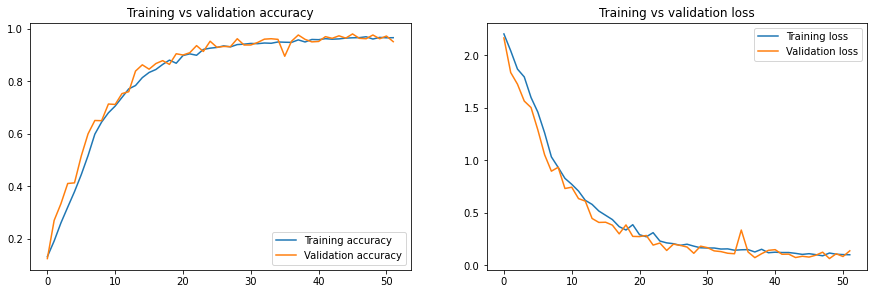

In [32]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [33]:
pred = model3.predict(test)

In [34]:
import numpy as np
pred = np.argmax(pred, axis=1)

In [35]:
labels = train.class_indices
labels

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [36]:
labels = dict((v,k) for k, v in labels.items())
labels

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

In [37]:
y_pred = [labels[k] for k in pred]
print(classification_report(x_test.label, y_pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.98      1.00      0.99       305
   Gilt-Head Bream       0.96      0.89      0.92       287
   Hourse Mackerel       0.83      1.00      0.91       298
        Red Mullet       1.00      1.00      1.00       290
     Red Sea Bream       0.93      0.96      0.94       291
          Sea Bass       0.98      0.81      0.89       301
            Shrimp       0.96      1.00      0.98       293
Striped Red Mullet       0.96      0.96      0.96       314
             Trout       0.98      0.94      0.96       321

          accuracy                           0.95      2700
         macro avg       0.95      0.95      0.95      2700
      weighted avg       0.95      0.95      0.95      2700



In [38]:
print(confusion_matrix(x_test.label, y_pred))

[[305   0   0   0   0   0   0   0   0]
 [  0 255   7   0  16   4   1   2   2]
 [  1   0 297   0   0   0   0   0   0]
 [  0   0   0 290   0   0   0   0   0]
 [  0   3   6   0 278   0   0   1   3]
 [  5   6  33   0   2 244   0  10   1]
 [  0   0   0   0   0   0 293   0   0]
 [  0   0   1   0   0   0  12 301   0]
 [  0   2  13   0   3   0   0   0 303]]


In [39]:
test_accuracy = model3.evaluate(test)[1]

85/85 [==============================] - 50s 590ms/step - loss: 0.1532 - accuracy: 0.9526
